# $\text{3.1 Synthetic numerical example}$

Importing libraries

In [18]:
import numpy as np 
# import cupy as np 
import seaborn as sn 
import matplotlib.pyplot as plt 
from sklearn.decomposition import TruncatedSVD
import cvxpy as cp

Creating synthetic inliers: ***A***, outliers: ***B***

In [19]:
# Create random matrices A: inlier
A =     np.random.rand(20, 200);                   #print(f'>> A{A.shape}:\n', A)
# Create random matrices B: outlier
B = 100*np.random.rand(20,  50);                   #print(f'>> B{B.shape}:\n', B)
# Create random matrices N: noise
N = 0.9*np.random.rand(20, 200);

A.shape, B.shape, N.shape

((20, 200), (20, 50), (20, 200))

Creating dataset ***D*** from **A**, ***B*** and ***N*** \
$D = [B (A+N)]T$ \
To simplify the exposition and notation, it is assumed without loss of generality that $T$ in Data Model 1 is the identity matrix, i.e, $D = [B A]$

>> D(20, 250):



<Axes: >

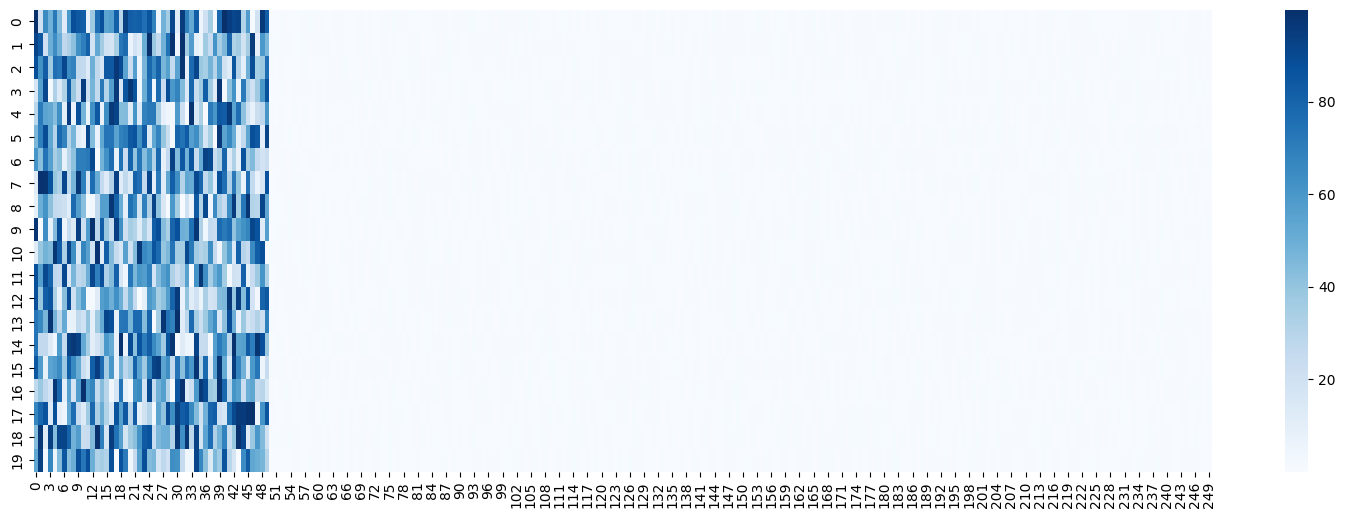

In [20]:
# Concatenate B(A+N)
D = np.hstack((B, A));   print(f'>> D{D.shape}:\n')

# plotting the heatmap 
plt.figure(figsize=(19,6))
sn.heatmap(data = D, cmap='Blues')

Create a permutation matrix T

>> D(20, 250):



<Axes: >

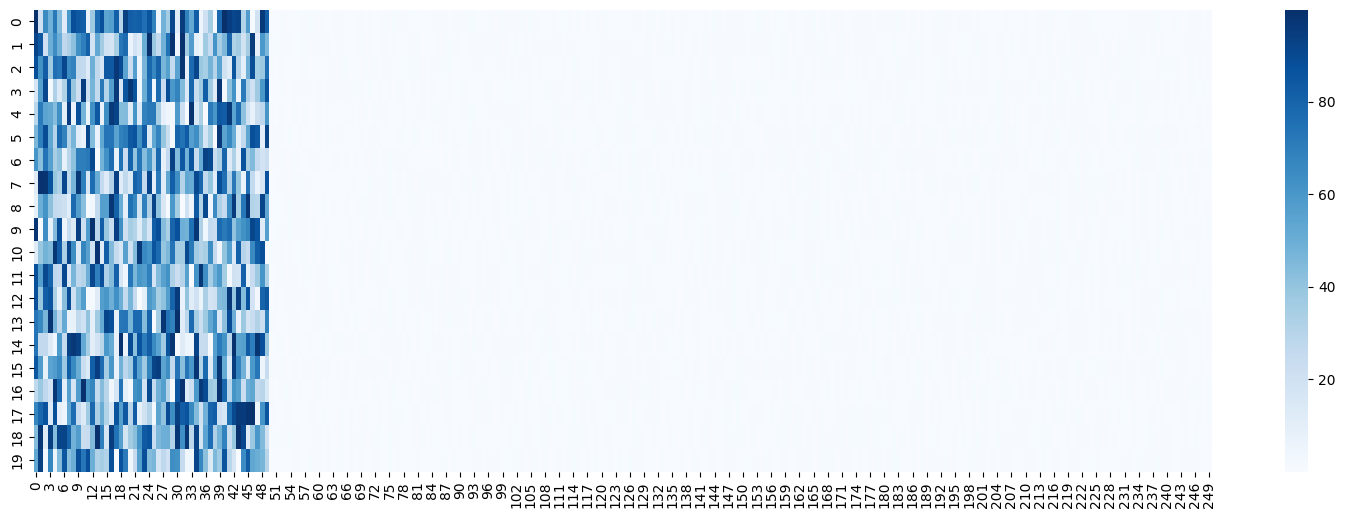

In [21]:
T = np.eye(D.shape[1])
D = D @ T;                           print(f'>> D{D.shape}:\n')

plt.figure(figsize=(19,6))
sn.heatmap(data = D, cmap="Blues")

Step 1: Data Preprocessing

In [ ]:
# D_new = D

>> D_new(20, 250)


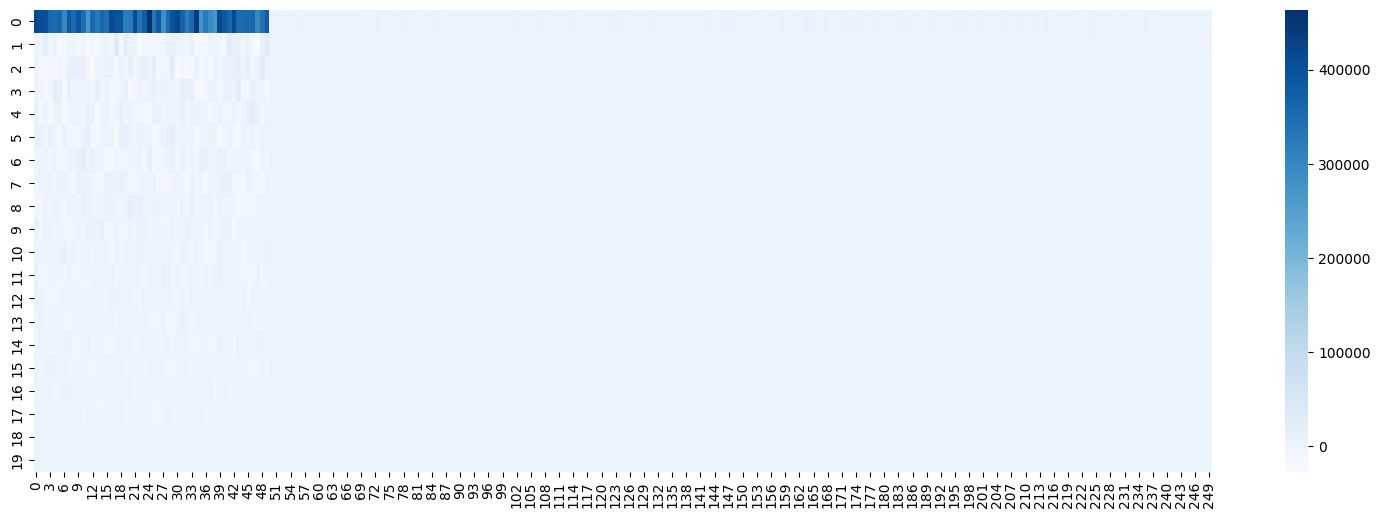

[1603.08312518  308.13690904  289.85893157  268.00946566  258.3835499
  250.82105898  234.96261326  228.5774386   211.38452915  200.66186967
  192.76166816  180.11023151  164.62636391  159.20745537  149.64701658
  145.70612824  131.41166461  115.6502698   100.49787413   95.22595611]


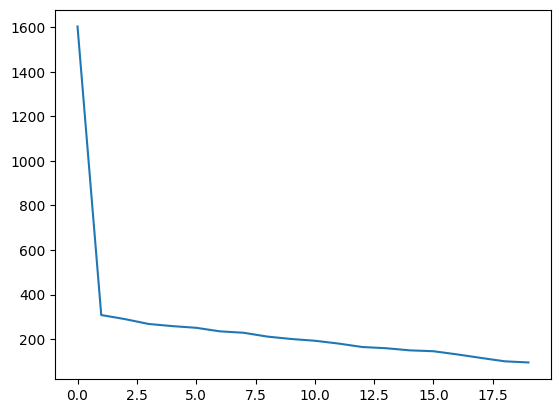

In [31]:
svd = TruncatedSVD(n_components=250);         # print('\n>> svd object:\n', svd)
Q = svd.fit_transform(D);                     # print('\n>> Q:\n', Q)
D_new = Q.T @ D;                               # print('\n>> D_new (Q.T @ D):\n', D_new, D_new.shape)

# Normalizing l-2 norm (opti`onal based on requirement)
# column_norms = np.linalg.norm(D_new, axis=0); #print('\n>> column_norms:\n', column_norms)
# D_new = D_new/column_norms;                   #print('\n>> D_new:\n', D_new, D_new.shape)

print(f'>> D_new{D_new.shape}')
plt.figure(figsize=(19,6))
sn.heatmap(data = D_new, cmap="Blues")
plt.show()

print(svd.singular_values_)
plt.plot(svd.singular_values_)
plt.show()

In [32]:
import cvxpy as cp # ADMM solver

# Assuming D_new is your data matrix after preprocessing (2,3)
M1, M2 = D_new.shape;                                             #print('>> M1, M2:\n', D_new.shape)
# This should be the number of non-zero singular values
rd = M1;                                                          #print('\n>> rd:\n', M1)

# Variable to be solved for
C = cp.Variable((rd, M2));                                        #print('\n>> C:\n', C)

# Defining the constraints
constraints = [cp.diag(C.T @ D_new) == 1];                        #print('\n>> constraints:\n', constraints)

# Defining the objective function
objective = cp.Minimize(cp.norm(C.T @ D_new, p=1));                 #print('\n>> objective:\n', objective)

# Defining the problem
problem = cp.Problem(objective, constraints);                     #print('\n>> problem:\n', problem)

# Solving the problem using ADMM solver
# Solving the problem using SCS solver (which uses ADMM)
problem.solve(solver=cp.SCS, verbose=True)

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Mar 29 01:25:03 AM: Your problem has 5000 variables, 1 constraints, and 0 parameters.
(CVXPY) Mar 29 01:25:03 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 29 01:25:03 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 29 01:25:03 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Mar 29 01:25:03 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 29 01:25:03 AM: Compiling problem (target solver=SCS).
(CV

In [ ]:
print(f"optimal objective value: {objective.value}")
C_star = C.value;     #print('\n>> C_star:\n', C.value)
print('C_star shape:', C_star.shape)
np.savetxt("c_star_svd250", C_star , delimiter=',')

Optimal values for C

In [ ]:
C_star = np.loadtxt("./c_star_svd250", delimiter=",")
C_star

Computing the innovation values

In [ ]:
1/np.linalg.norm(D_new.T @ C_star[:,0], ord=1)

In [ ]:
x = 1 / np.linalg.norm(D_new.T @ C_star, axis=0, ord=1);  print(f'x {x.shape}:\n', x)
plt.figure(figsize=(7,4))
plt.plot(x)

In [ ]:
plt.figure(figsize=(19,4))

plt.subplot(1,3,1)
plt.stem(np.arange(0,250), np.hstack([(C_star.T @ D_new)[0,:50], np.zeros(200)]), linefmt ='blue', markerfmt ='+')
plt.xlabel('Element Index'); plt.ylabel(r'$\mathbf{c^{*}D}$'); plt.title("d ins an outliers (B), p=1")
# plt.ylim(-0.5,1), plt.xlim(0,250)

plt.subplot(1,3,2)
plt.stem(np.arange(0,250), np.hstack([np.zeros(50), (C_star.T @ D_new)[0,50:]]), linefmt ='blue', markerfmt ='+')[0].set_markerfacecolor('none')
# plt.stem(np.arange(0,250), (C_star.T @ D_new)[0,:], linefmt ='blue', markerfmt ='+')
plt.xlabel('Element Index'); plt.ylabel(r'$\mathbf{c^{*}D}$'); plt.title("d ins an inliers (A), p=1")
# plt.ylim(-1.5,1.5), plt.xlim(0,250)

plt.subplot(1,3,3)
plt.stem(np.arange(0,250), x, linefmt ='blue', markerfmt ='+')
plt.xlabel('Element Index'); plt.ylabel(r'$\mathbf{X}$'); plt.title("Innovation Values, p=1")